### Demodulation - Compare Methods

## Import 

### Official Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import os

from scipy.signal import resample, hilbert, correlate
from tqdm import tqdm
from obspy import UTCDateTime, read, Stream, read_inventory

from andbro__read_sds import __read_sds

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

### Own Plotting Methods

In [3]:
import sys
sys.path.insert(0, 'submodules')

## Configurations

In [4]:
config = {}

config['ring'] = "Z"

config['path_to_data'] = archive_path+"romy_archive/"

config['path_to_tmp'] = archive_path+"temp_archive/"

config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

config['tbeg'] = UTCDateTime("2024-07-11 15:00")
config['tend'] = UTCDateTime("2024-07-11 17:00")

### Load Data

1 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-07-11T14:59:59.979200Z - 2024-07-11T16:59:59.979200Z | 20.0 Hz, 144001 samples


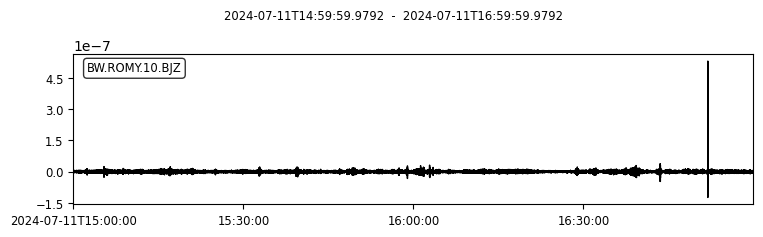

In [5]:
st_classic = __read_sds(config['path_to_data'], f"BW.ROMY.10.BJ{config['ring']}", config['tbeg'], config['tend'])

romy_inv = read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

st_classic = st_classic.remove_sensitivity(romy_inv)

st_classic = st_classic.detrend("linear")

print(st_classic)

st_classic.plot();

### Load Processed Data

In [6]:
# st_modifed = __read_sds(config['path_to_data'], "BW.ROMY.30.BJN", config['tbeg'], config['tend'])

# st_modifed = st_modifed.detrend("linear")

# st_modifed.plot();

### Load Sine Data

In [7]:
def __interpolate_nan(array_like):

    from numpy import isnan, interp

    array = array_like.copy()

    nans = isnan(array)

    def get_x(a):
        return a.nonzero()[0]

    array[nans] = interp(get_x(nans), get_x(~nans), array[~nans])

    return array

1 Trace(s) in Stream:
BW.ROMY.60.BJZ | 2024-07-11T15:00:00.000000Z - 2024-07-11T17:00:00.000000Z | 20.0 Hz, 144001 samples


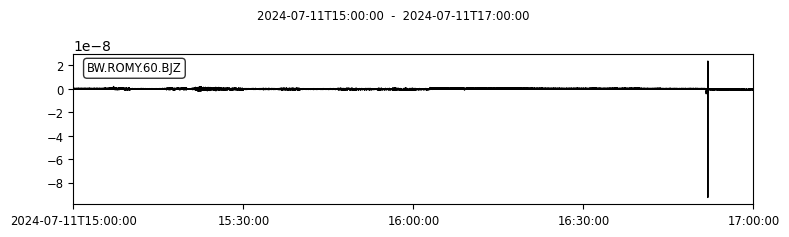

In [8]:
st_sine = __read_sds(config['path_to_tmp'], f"BW.ROMY.60.BJ{config['ring']}", config['tbeg'], config['tend'])

st_sine = st_sine.merge(fill_value="interpolate")

for tr in st_sine:
    tr.data = __interpolate_nan(tr.data)

st_sine = st_sine.detrend("linear")

print(st_sine)

st_sine.plot();

### Load Hilbert2 Data

1 Trace(s) in Stream:
BW.ROMY.80.BJZ | 2024-07-11T15:00:00.000000Z - 2024-07-11T17:00:00.000000Z | 20.0 Hz, 144001 samples


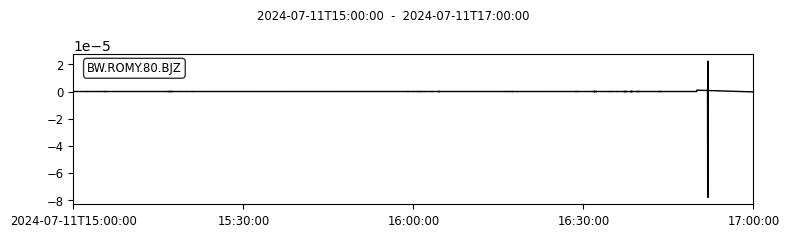

In [57]:
st_hilbert = __read_sds(config['path_to_tmp'], f"BW.ROMY.80.BJ{config['ring']}", config['tbeg'], config['tend'])

st_hilbert = st_hilbert.detrend("linear")

st_hilbert = st_hilbert.merge(fill_value=0)

print(st_hilbert)

st_hilbert.plot();

### Combine to one Stream

3 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-07-11T14:59:59.979200Z - 2024-07-11T16:59:59.979200Z | 20.0 Hz, 144001 samples
BW.ROMY.60.BJZ | 2024-07-11T15:00:00.000000Z - 2024-07-11T17:00:00.000000Z | 20.0 Hz, 144001 samples
BW.ROMY.80.BJZ | 2024-07-11T15:00:00.000000Z - 2024-07-11T17:00:00.000000Z | 20.0 Hz, 144001 samples


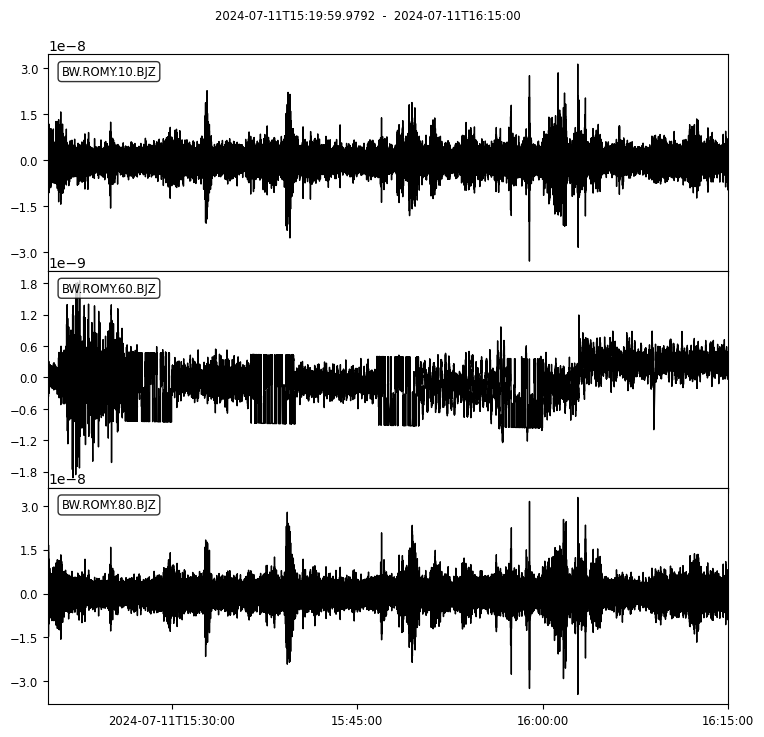

In [58]:
stt = Stream()

stt += st_classic.copy()
stt += st_hilbert.copy()
stt += st_sine.copy()

stt = stt.merge(fill_value="interpolate")

stt = stt.sort()

print(stt)

t1 = UTCDateTime("2024-07-11 15:20")
t2 = UTCDateTime("2024-07-11 16:15")

stt = stt.trim(t1, t2)

stt.plot(equal_scale=False);

In [61]:
stt = stt.taper(0.01)

fmin, fmax = 0.001, 0.2
stt = stt.filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4)

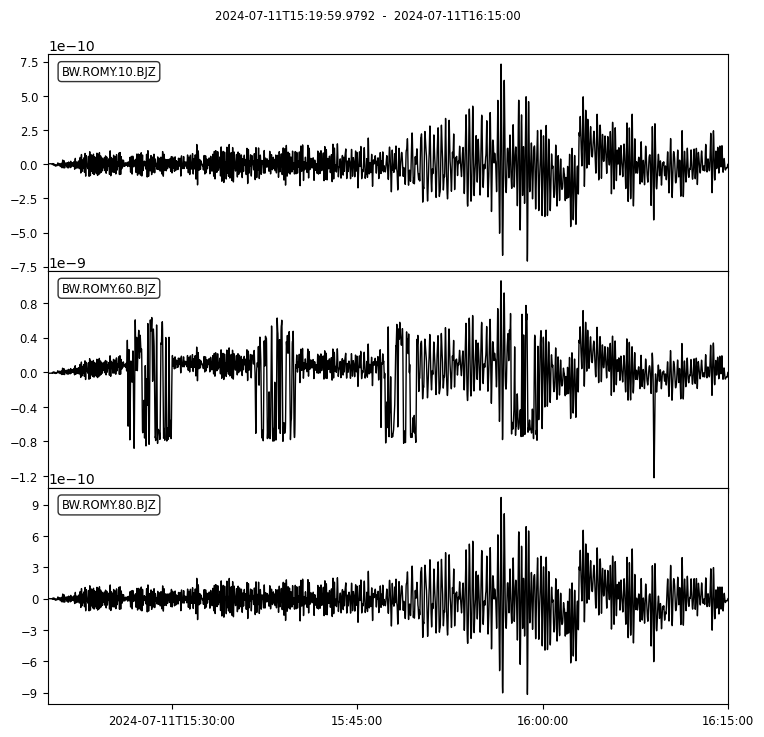

In [62]:
stt.plot(equal_scale=False);

In [34]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    for _i, tr in enumerate(stt):
        ax[_i].plot(tr.times(), tr.data, label=f"{tr.stats.location}")
        y_max = np.nanpercentile(abs(tr.data), 97)
        ax[_i].set_ylim(-y_max, y_max)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

# fig = __makeplot();


In [35]:
# for tr in stt:
#     if tr.stats.location == "60":
#         tr.data = np.roll(tr.data, int(0.45*20))

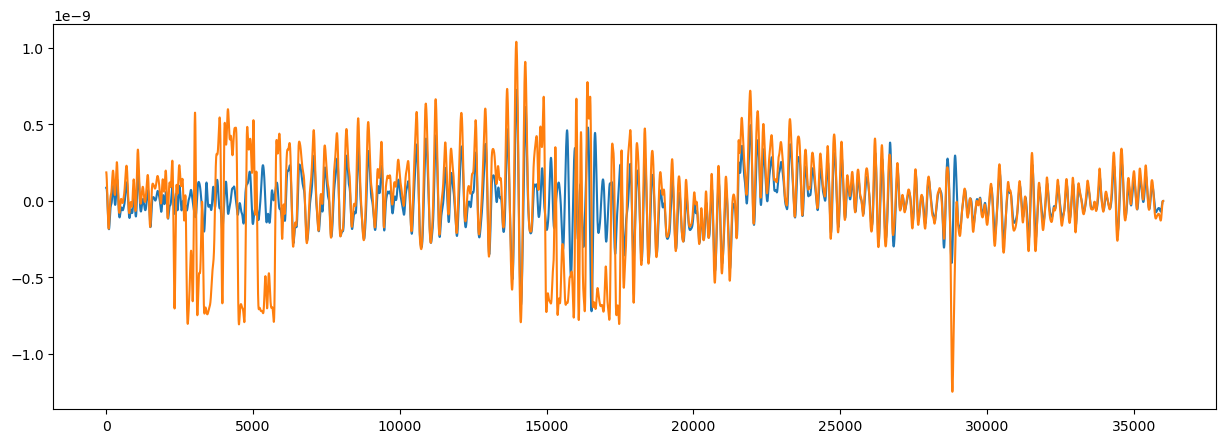

In [43]:
plt.figure(figsize=(15, 5))
plt.plot(stt.select(location="10")[0].data[30000:])
plt.plot(stt.select(location="60")[0].data[30000:])
# plt.plot(stt.select(location="80")[0].data[30000:])


Nshift:  -3 Tshift:  -0.15000000000000002 CC:  0.9900174939937478


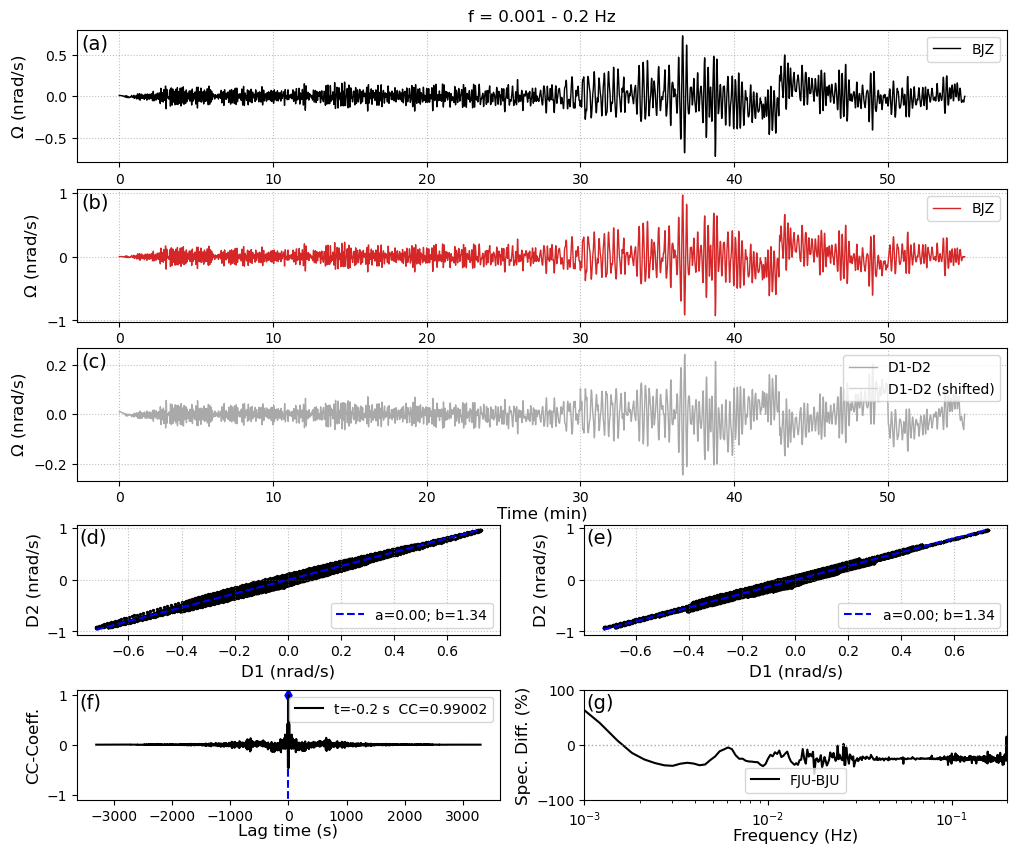

In [56]:
def __compare(st1, st2, fmin=0.01, fmax=10):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace, imag, roll, nan
    from scipy.signal import hilbert
    from matplotlib.gridspec import GridSpec
    from submodules.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from submodules.get_fft import __get_fft

    dt = st1[0].stats.delta

    tscale, tunit = 1/60, "min"
    yscale, yunit = 1e9, "nrad/s"

    times = st1[0].times()*tscale

    arr1 = st1[0].data*yscale
    arr2 = st2[0].data*yscale

    # arr1 /= max(abs(arr1))
    # arr2 /= max(abs(arr2))

    Nshift = len(arr1)

    ccf = correlate(arr1, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift, value = xcorr_max(ccf)

    arr2_shifted = roll(arr2, shift)

    print("Nshift: ", shift, "Tshift: ", shift*dt, "CC: ", value)


    b1, a1 = __compute_orthogonal_distance_regression(arr1, arr2, xerr=None, yerr=None, bx=None, by=None)

    b1_shifted, a1_shifted = __compute_orthogonal_distance_regression(arr1, arr2_shifted, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr1.min(), arr1.max(), 100)

    res0 = arr1 - arr2

    res = arr1 - arr2_shifted

    if shift != 0:
        res[:2*shift] *= nan
        res[-2*shift:] *= nan

    spec1, f1, p1 = __get_fft(arr1, dt, window='hann')
    spec2, f2, p2 = __get_fft(arr2_shifted, dt, window='hann')


    # ___________________________________________
    #

    Nrow, Ncol = 5, 2

    font = 12

    lw = 1

    fig = plt.figure(figsize=(12, 10))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.2)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :])
    ax4 = fig.add_subplot(gs0[3, :1])
    ax5 = fig.add_subplot(gs0[3, 1:])
    ax6 = fig.add_subplot(gs0[4, :1])
    ax7 = fig.add_subplot(gs0[4, 1:])

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr1, color="black", label=f"{st1[0].stats.channel}", lw=lw)
    ax1.set_ylabel(f"$\Omega$ ({yunit})", fontsize=font)
    # ax1.get_xaxis().set_visible(False)
    ax1.legend(loc=1)

    ax2.plot(times, arr2, color="tab:red", label=f"{st2[0].stats.channel}", lw=lw)
    ax2.legend(loc=1, ncol=1)
    ax2.set_ylabel(f"$\Omega$ ({yunit})", fontsize=font)

    ax3.plot(times, res0, color="darkgrey", label=f"D1-D2", lw=lw)
    ax3.plot(times, res, color="lightgrey", label=f"D1-D2 (shifted)", lw=lw)
    ax3.legend(loc=1, ncol=1)
    ax3.set_ylabel(f"$\Omega$ ({yunit})", fontsize=font)
    ax3.set_xlabel(f"Time ({tunit})", fontsize=font, labelpad=1)

    ax4.scatter(arr1, arr2, color="black", s=2)
    ax4.plot(xxx, (a1+b1*xxx), ls="--", color="b", label=f"a={a1:.2f}; b={b1:.2f}")
    ax4.set_xlabel(f"D1 ({yunit})", fontsize=font)
    ax4.set_ylabel(f"D2 ({yunit})", fontsize=font)
    ax4.legend(loc=4)

    ax5.scatter(arr1, arr2_shifted, color="black", s=2)
    ax5.plot(xxx, (a1_shifted+b1_shifted*xxx), ls="--", color="b", label=f"a={a1_shifted:.2f}; b={b1_shifted:.2f}")
    ax5.set_xlabel(f"D1 ({yunit})", fontsize=font)
    ax5.set_ylabel(f"D2 ({yunit})", fontsize=font)
    ax5.legend(loc=4)

    ll = f"t={round(shift*dt, 1)} s  CC={round(value, 5)}"
    ax6.plot(cclags, ccf, color="k", label=ll)
    ax6.set_ylabel("CC-Coeff.", fontsize=font)
    ax6.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax6.set_ylim(-1.1, 1.1)
    ax6.axvline(shift*dt, -1, 1, color="b", ls="--", zorder=0)
    ax6.scatter(shift*dt, value, color="b", marker="d", zorder=0)
    ax6.legend()
    # ax6.text(.005, .97, ll, ha='left', va='top', transform=ax6.transAxes, fontsize=font)

    ax7.plot(f1, (spec1-spec2)/spec2*100, color="k", label=f"FJU-BJU")
    # ax7.plot(f2, spec2, color="tab:red", label=f"BJU")
    ax7.axhline(0, 0, 100, color="darkgrey", ls=":", lw=1)
    ax7.set_ylabel("Spec. Diff. (%)", fontsize=font)
    ax7.set_xlabel("Frequency (Hz)", fontsize=font, labelpad=0)
    ax7.set_xscale("log")
    ax7.set_xlim(fmin, fmax)
    ax7.legend(ncol=2, loc=8)
    ax7.set_ylim(-100, 100)

    for _k, (ax, ll) in enumerate(zip([ax1, ax2, ax3, ax4, ax5, ax6, ax7], ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)


    ax1.set_title(f"f = {fmin} - {fmax} Hz")

    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

    plt.show();
    return fig

st1 = stt.select(location="10").copy()
st2 = stt.select(location="60").copy()
# st2 = stt.select(location="80").copy()

fig = __compare(st1, st2, fmin, fmax)

# fig.savefig(path_to_figs+f"SP_{date}_{fmin}_{fmax}_comparison.png", format="png", dpi=150, bbox_inches='tight')


### Compare Freq and Phase

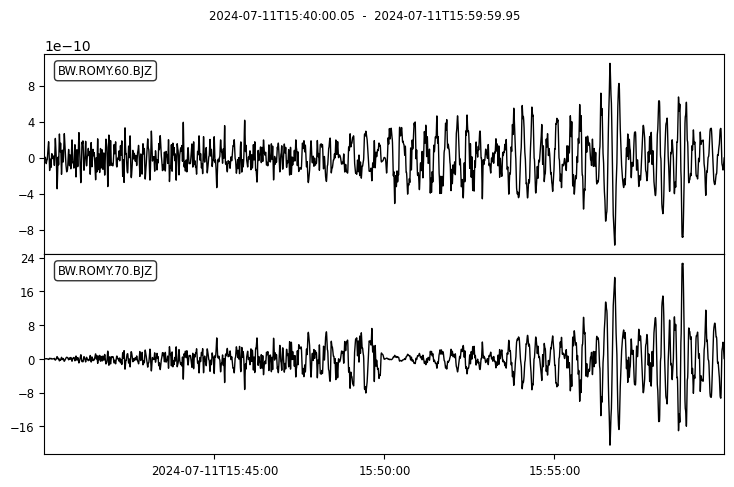

In [77]:
st0 = Stream()
st0 += __read_sds(config['path_to_tmp'], f"BW.ROMY.60.BJ{config['ring']}", config['tbeg'], config['tend'])
st0 += __read_sds(config['path_to_tmp'], f"BW.ROMY.70.BJ{config['ring']}", config['tbeg'], config['tend'])

# for tr in st0:
#     if tr.stats.location == "70":
#         tr = tr.differentiate(method="gradient")

t1 = UTCDateTime("2024-07-11 15:40")
t2 = UTCDateTime("2024-07-11 16:00")
st0 = st0.trim(t1, t2)

st0 = st0.detrend("linear")
st0 = st0.taper(0.01)

fmin, fmax = 0.001, 0.5
st0 = st0.filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4)

st0.plot(equal_scale=False);

In [81]:
test = np.array([1 ,2, 3, np.nan])

test[~np.isnan(test)][-1]


3.0

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(st0.select(location="60")[0].normalize().data)
plt.plot(-st0.select(location="70")[0].normalize().data)


## Load Phase

12 Trace(s) in Stream:
BW.ROMY.70.BJZ | 2024-07-11T15:00:00.000000Z - 2024-07-11T15:09:59.950000Z | 20.0 Hz, 12000 samples
BW.ROMY.70.BJZ | 2024-07-11T15:10:00.050000Z - 2024-07-11T15:19:59.950000Z | 20.0 Hz, 11999 samples
BW.ROMY.70.BJZ | 2024-07-11T15:20:00.050000Z - 2024-07-11T15:29:59.950000Z | 20.0 Hz, 11999 samples
BW.ROMY.70.BJZ | 2024-07-11T15:30:00.050000Z - 2024-07-11T15:39:59.950000Z | 20.0 Hz, 11999 samples
BW.ROMY.70.BJZ | 2024-07-11T15:40:00.050000Z - 2024-07-11T15:49:59.950000Z | 20.0 Hz, 11999 samples
BW.ROMY.70.BJZ | 2024-07-11T15:50:00.050000Z - 2024-07-11T15:59:59.950000Z | 20.0 Hz, 11999 samples
BW.ROMY.70.BJZ | 2024-07-11T16:00:00.050000Z - 2024-07-11T16:09:59.950000Z | 20.0 Hz, 11999 samples
BW.ROMY.70.BJZ | 2024-07-11T16:10:00.050000Z - 2024-07-11T16:19:59.950000Z | 20.0 Hz, 11999 samples
BW.ROMY.70.BJZ | 2024-07-11T16:20:00.050000Z - 2024-07-11T16:29:59.950000Z | 20.0 Hz, 11999 samples
BW.ROMY.70.BJZ | 2024-07-11T16:30:00.050000Z - 2024-07-11T16:39:59.950000Z | 

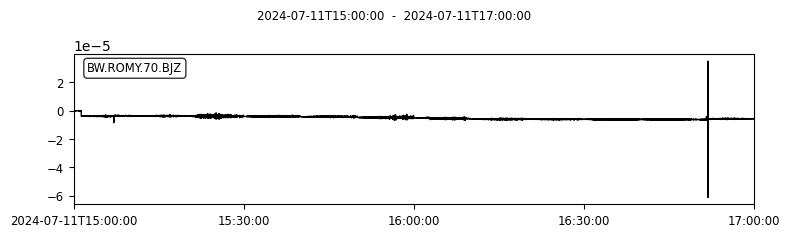

In [18]:
st_phase = __read_sds(config['path_to_tmp'], f"BW.ROMY.70.BJ{config['ring']}", config['tbeg'], config['tend'])

print(st_phase)

st_phase = st_phase.merge(fill_value=np.nan)
# st_phase = st_phase.split()

for tr in st_phase:
    tr.data = __interpolate_nan(tr.data)

    # scaling ???
    tr.data = tr.data / (2*np.pi) * 632.8e-9

    tr.data -= np.nanmean(tr.data[:10])

# st_phase = st_phase.detrend("linear")

print(st_phase)

st_phase.plot();

In [19]:
st_fur = __read_sds(bay_path+"mseed_online/archive/", "GR.FUR..BHE", config['tbeg'], config['tend'])

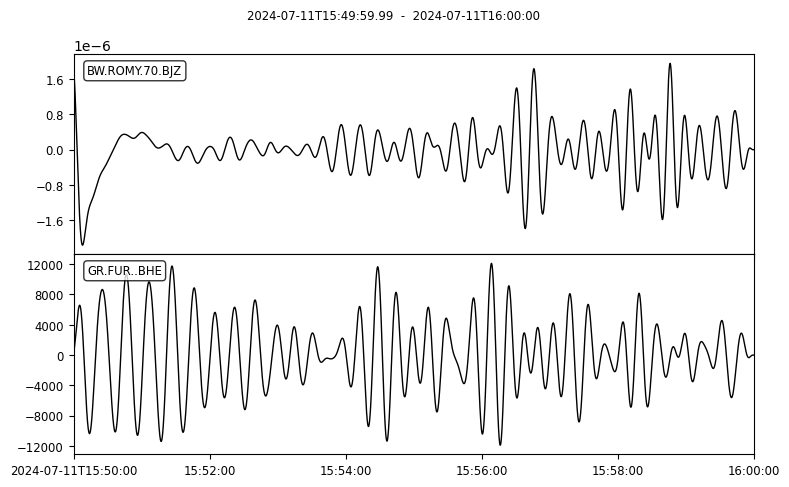

In [20]:
stx = Stream()

stx += st_phase
# stx += st_sine
stx += st_fur

stx = stx.trim(t1, t2)

stx = stx.taper(0.01)

fmin, fmax = 0.01, 0.1
stx = stx.filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4)

stx.plot(equal_scale=False);